In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
#https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/data?select=Y.npy

In [3]:
train_batch_size = 16
X = np.load('X.npy') # images
Y = np.load('Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)
X = X.transpose((0, 3, 1, 2)) # (N, H, W, C) -> (N, C, H, W)
X = X.astype(np.float32) / 255
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 
X_train=torch.tensor(X_train)
Y_train=torch.tensor(Y_train)
X_test=torch.tensor(X_test)
Y_test=torch.tensor(Y_test)
train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,Y_train), batch_size=train_batch_size)
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test,Y_test))

In [4]:
def flatten(x):
    return x.reshape(x.shape[0], -1)

class FirstNetwork(nn.Module):
    
    def __init__(self):
        super(FirstNetwork, self).__init__()
        self.first_layer = nn.Linear(7500, 256)
        self.second_layer = nn.Linear(256, 2)
        
       
    def forward(self, x):
        o = flatten(x)
        o = self.first_layer(o)
        o = nn.functional.relu(o)
        logits = self.second_layer(o)
        return nn.functional.softmax(logits, dim=-1)
    


In [5]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.first_conv = nn.Conv2d(3, 6, kernel_size=9, padding=3)  
        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.relu = nn.ReLU()
        self.second_conv = nn.Conv2d(6, 6, kernel_size=3, padding=1)
        self.final_layer = nn.Linear(150, 2)
        
    def forward(self, x):
        first_result = self.relu(self.MaxPool(self.first_conv(x)))
        #print(first_result.shape)
        second_result = self.relu(self.MaxPool(self.second_conv(first_result)))
        #print(second_result.shape) # (16, 6, 5, 5)
        res = flatten(second_result) # (16, 150(=6x5x5))
        logits = self.final_layer(res)
        return nn.functional.softmax(logits, dim=-1)
    
def get_accuracy(net, test_dataloader):
    total = 0
    correct = 0
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            output = torch.argmax(net(X)[0])
            if output == y:
                correct += 1
            total += 1
        return correct / total

In [6]:
net = ConvNet() 

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=3e-5)
losses = []

In [8]:
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    batch_num = 0
    for X, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        output = net(X)
        loss = torch.sum(-1 * torch.log(output.gather(1, y.reshape(-1, 1)))) / train_batch_size
        loss.backward()
        optimizer.step()
        l = loss.detach()
        total_loss += l
        batch_num += 1
        
    print("Loss", total_loss / batch_num)
    losses.append(total_loss / batch_num)
    

  8%|▊         | 21/278 [00:00<00:01, 204.43it/s]

Loss tensor(0.6948)


  8%|▊         | 22/278 [00:00<00:01, 212.10it/s]

Loss tensor(0.6909)


  7%|▋         | 20/278 [00:00<00:01, 198.55it/s]

Loss tensor(0.6898)


  8%|▊         | 21/278 [00:00<00:01, 202.34it/s]

Loss tensor(0.6884)


  9%|▊         | 24/278 [00:00<00:01, 230.82it/s]

Loss tensor(0.6866)


  8%|▊         | 21/278 [00:00<00:01, 205.57it/s]

Loss tensor(0.6842)


  8%|▊         | 22/278 [00:00<00:01, 214.16it/s]

Loss tensor(0.6812)


  8%|▊         | 21/278 [00:00<00:01, 198.64it/s]

Loss tensor(0.6775)


 15%|█▌        | 43/278 [00:00<00:01, 209.28it/s]

Loss tensor(0.6725)


  8%|▊         | 22/278 [00:00<00:01, 206.53it/s]

Loss tensor(0.6638)


 15%|█▍        | 41/278 [00:00<00:01, 190.50it/s]

Loss tensor(0.6535)


  7%|▋         | 19/278 [00:00<00:01, 188.62it/s]

Loss tensor(0.6428)


 11%|█         | 31/278 [00:00<00:01, 155.73it/s]

Loss tensor(0.6330)


 13%|█▎        | 37/278 [00:00<00:01, 179.27it/s]

Loss tensor(0.6243)


  6%|▌         | 17/278 [00:00<00:01, 160.80it/s]

Loss tensor(0.6169)


  6%|▋         | 18/278 [00:00<00:01, 170.27it/s]

Loss tensor(0.6093)


 13%|█▎        | 37/278 [00:00<00:01, 180.61it/s]

Loss tensor(0.5980)


  6%|▋         | 18/278 [00:00<00:01, 176.95it/s]

Loss tensor(0.5924)


  6%|▋         | 18/278 [00:00<00:01, 175.22it/s]

Loss tensor(0.5879)


100%|██████████| 278/278 [00:01<00:00, 161.03it/s]

Loss tensor(0.5840)


In [9]:
get_accuracy(net, test_dataloader)

100%|██████████| 1110/1110 [00:00<00:00, 1805.18it/s]


0.7036036036036036

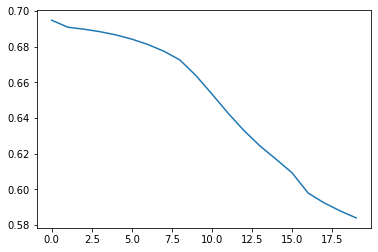

In [10]:
plt.plot(losses)

In [11]:
net(X_test[:6])
#according to the website 0=ICD- and 1=ICD+
#Here I run the code for the 6 first picture and where the second element is larger than the first element it's malignant
#otherwise it's benign

tensor([[0.5492, 0.4508],
        [0.4794, 0.5206],
        [0.4730, 0.5270],
        [0.4833, 0.5167],
        [0.4613, 0.5387],
        [0.7061, 0.2939]], grad_fn=<SoftmaxBackward>)